In [259]:
%config IPCompleter.greedy=True 
%matplotlib inline

In [353]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
# from models.schemas import Base, DublinBike
# from config import MySQL
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.externals import joblib



# host = MySQL.host
# user = MySQL.username
# password = MySQL.password
# database = MySQL.database

# engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')
# Base.metadata.create_all(engine)

# session = sessionmaker()
# session.configure(bind=engine)
# s = session()

# query_bike = "SELECT *\
#          FROM dublin_bike"

# query_weather = "SELECT *\
#          FROM current_weather\
#          WHERE number = %(number)s"

# bike_df = pd.read_sql_table(table_name="dublin_bike", schema="development",  con=engine, parse_dates=['scraping_time'])
# weather_df = pd.read_sql_table(table_name="current_weather", schema="development",  con=engine, parse_dates=['scraping_time'])
# weather_df.to_pickle("./weather_df.pkl")
# bike_df.to_pickle("./bike_df.pkl")

bike_df = pd.read_pickle("./bike_df.pkl")
weather_df = pd.read_pickle("./weather_df.pkl")

FileNotFoundError: [Errno 2] No such file or directory: './bike_df.pkl'

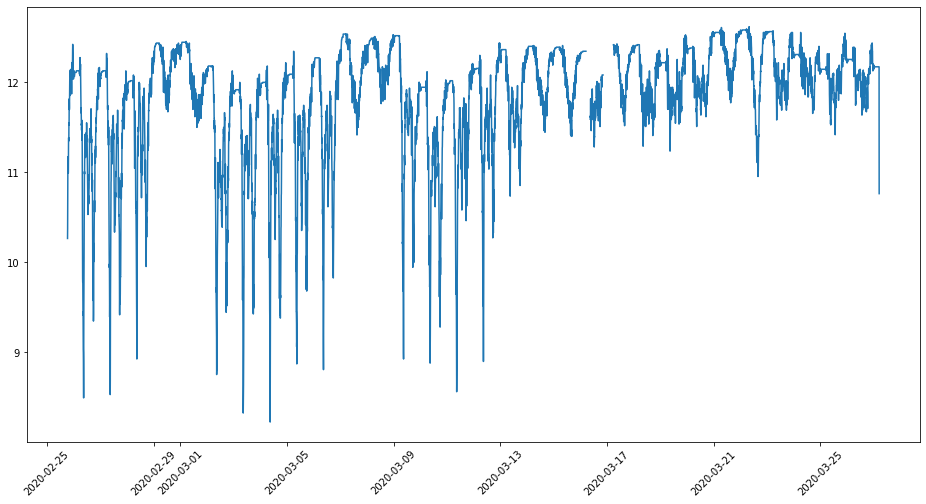

In [354]:
bike_df2 = bike_df[bike_df["number"] == 100]
bike_df2 = bike_df.resample('5Min', on='scraping_time').mean()

f, axs = plt.subplots(figsize=(16,8))
plt.plot(bike_df2['available_bike'])
plt.xticks(rotation = 45)
plt.show()

In [355]:
def line_graph(bike_df, number):
    return

In [356]:
def datetime_conversion(df, df_col):
    df['hour'] = df[df_col].dt.hour
    return df

In [357]:
def merge_df(bike_df, weather_df):
    combined_df = pd.merge(bike_df, weather_df,  how='inner',\
                           left_on=['number', 'scraping_time'],\
                           right_on = ['stationNum', 'datetime'],\
                           suffixes=('_bike','_weather'))
    return combined_df

In [358]:
def time_transform(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df = df.drop([col], axis = 1)
    return df

In [359]:
def data_cleaning(df):
    pd.set_option('display.max_columns', 500)
    col_to_drop = ['address', 'site_names','bonus', 'last_update', 'datetime',\
                   'icon', 'lon', 'lat', 'stationNum', 'sunset','available_bike_stand','description','status']
    df = df.drop(col_to_drop, axis = 1)
    df = df.drop_duplicates().reset_index()
    df = df.drop(['index'] ,axis = 1)
    df = df.drop(['scraping_time','available_bike'] ,axis = 1)

    return df

In [360]:
def data_type_conversion(df):
    categorical_col = ['code']
    df[categorical_col] = df[categorical_col].astype('category')
#     df['code'] = df['code'].astype('int32')
    df['banking'] = df['banking'].astype('int32')
    df['temperature'] = df['temperature'].astype('float64')
#     status_map = {'OPEN':1,'CLOSE':0}
#     df['status'] = df['status'].map(status_map)
    return df

In [361]:
def one_hot_encoding(df, col_list):
    df = pd.get_dummies(df, prefix = col_list, columns = col_list)
    return df

In [362]:
bike_df['available_bike_ratio'] = bike_df['available_bike'] / bike_df['bike_stand']
bike_df['available_bike_ratio_label'] = bike_df['available_bike_ratio'].shift(-1308)
bike_df.dropna(inplace=True)
bike_df

,scraping_time,number,last_update,address,site_names,latitude,longitude,bike_stand,available_bike_stand,available_bike,status,banking,bonus,available_bike_ratio,available_bike_ratio_label
0,2020-02-25 18:25:02,2,2020-02-25 18:24:11,Blessington Street,BLESSINGTON STREET,53.3568,-6.26814,20,15,5,OPEN,1,0,0.250000,0.050000
1,2020-02-25 18:25:02,3,2020-02-25 18:16:34,Bolton Street,BOLTON STREET,53.3512,-6.26986,20,20,0,OPEN,0,0,0.000000,0.000000
2,2020-02-25 18:25:02,4,2020-02-25 18:21:57,Greek Street,GREEK STREET,53.3469,-6.27298,20,20,0,OPEN,0,0,0.000000,0.150000
3,2020-02-25 18:25:02,5,2020-02-25 18:24:50,Charlemont Street,CHARLEMONT PLACE,53.3307,-6.26018,40,34,6,OPEN,0,0,0.150000,0.300000
4,2020-02-25 18:25:02,6,2020-02-25 18:20:29,Christchurch Place,CHRISTCHURCH PLACE,53.3434,-6.27012,20,15,5,OPEN,0,0,0.250000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946017,2020-03-27 04:05:02,87,2020-03-27 04:00:18,Collins Barracks Museum,COLLINS BARRACKS MUSEUM,53.3475,-6.28525,38,17,21,OPEN,1,0,0.552632,0.425000
946018,2020-03-27 04:05:02,88,2020-03-27 04:01:25,Blackhall Place,BLACKHALL PLACE,53.3488,-6.28164,30,13,17,OPEN,0,0,0.566667,0.421053
946019,2020-03-27 04:05:02,89,2020-03-27 04:02:17,Fitzwilliam Square East,FITZWILLIAM SQUARE EAST,53.3352,-6.25090,40,31,9,OPEN,1,0,0.225000,0.206897
946020,2020-03-27 04:05:02,90,2020-03-27 04:03:18,Benson Street,BENSON STREET,53.3442,-6.23345,40,31,9,OPEN,0,0,0.225000,0.575000


In [363]:
combined_df = merge_df(bike_df, weather_df)
combined_df = datetime_conversion(combined_df, "scraping_time")
combined_df

,scraping_time,number,last_update,address,site_names,latitude,longitude,bike_stand,available_bike_stand,available_bike,status,banking,bonus,available_bike_ratio,available_bike_ratio_label,datetime,temperature,description,icon,lon,lat,wind_spd,clouds,sunset,code,weekday,stationNum,hour
0,2020-03-24 10:52:00,2,2020-03-24 10:46:25,Blessington Street,BLESSINGTON STREET,53.3568,-6.26814,20,3,17,OPEN,1,0,0.850000,0.350000,2020-03-24 10:52:00,11.8,broken clouds,04d,-6.27,53.36,1.0,75.0,1585075524,803,2,2,10
1,2020-03-24 10:52:00,3,2020-03-24 10:50:43,Bolton Street,BOLTON STREET,53.3512,-6.26986,20,11,9,OPEN,0,0,0.450000,0.150000,2020-03-24 10:52:00,10.95,broken clouds,04d,-6.27,53.35,2.6,75.0,1585075523,803,2,3,10
2,2020-03-24 10:52:00,4,2020-03-24 10:47:27,Greek Street,GREEK STREET,53.3469,-6.27298,20,6,14,OPEN,0,0,0.700000,0.300000,2020-03-24 10:52:00,10.95,broken clouds,04d,-6.27,53.35,2.6,75.0,1585075523,803,2,4,10
3,2020-03-24 10:52:00,5,2020-03-24 10:41:25,Charlemont Street,CHARLEMONT PLACE,53.3307,-6.26018,40,18,22,OPEN,0,0,0.550000,0.344828,2020-03-24 10:52:00,10.95,broken clouds,04d,-6.26,53.33,2.6,75.0,1585075520,803,2,5,10
4,2020-03-24 10:52:00,6,2020-03-24 10:46:54,Christchurch Place,CHRISTCHURCH PLACE,53.3434,-6.27012,20,14,6,OPEN,0,0,0.300000,0.500000,2020-03-24 10:52:00,11.8,broken clouds,04d,-6.27,53.34,1.0,75.0,1585075523,803,2,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85317,2020-03-27 04:05:02,87,2020-03-27 04:00:18,Collins Barracks Museum,COLLINS BARRACKS MUSEUM,53.3475,-6.28525,38,17,21,OPEN,1,0,0.552632,0.425000,2020-03-27 04:05:02,6.3,broken clouds,04n,-6.29,53.35,4.1,75.0,1585335053,803,5,87,4
85318,2020-03-27 04:05:02,88,2020-03-27 04:01:25,Blackhall Place,BLACKHALL PLACE,53.3488,-6.28164,30,13,17,OPEN,0,0,0.566667,0.421053,2020-03-27 04:05:02,6.3,broken clouds,04n,-6.28,53.35,4.1,75.0,1585335050,803,5,88,4
85319,2020-03-27 04:05:02,89,2020-03-27 04:02:17,Fitzwilliam Square East,FITZWILLIAM SQUARE EAST,53.3352,-6.25090,40,31,9,OPEN,1,0,0.225000,0.206897,2020-03-27 04:05:02,6.31,broken clouds,04n,-6.25,53.34,4.1,75.0,1585335043,803,5,89,4
85320,2020-03-27 04:05:02,90,2020-03-27 04:03:18,Benson Street,BENSON STREET,53.3442,-6.23345,40,31,9,OPEN,0,0,0.225000,0.575000,2020-03-27 04:05:02,6.3,broken clouds,04n,-6.23,53.34,4.1,75.0,1585335038,803,5,90,4


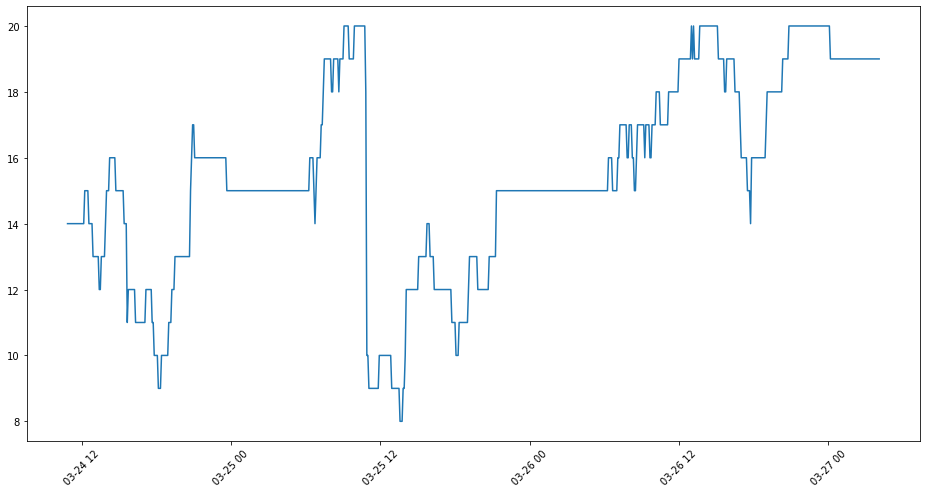

In [364]:
combined_df2 = combined_df[combined_df["number"] == 4]
combined_df2 = combined_df2.set_index("scraping_time")
f, axs = plt.subplots(figsize=(16,8))
plt.plot(combined_df2['available_bike'])
plt.xticks(rotation = 45)
plt.show()

In [365]:
combined_df

,scraping_time,number,last_update,address,site_names,latitude,longitude,bike_stand,available_bike_stand,available_bike,status,banking,bonus,available_bike_ratio,available_bike_ratio_label,datetime,temperature,description,icon,lon,lat,wind_spd,clouds,sunset,code,weekday,stationNum,hour
0,2020-03-24 10:52:00,2,2020-03-24 10:46:25,Blessington Street,BLESSINGTON STREET,53.3568,-6.26814,20,3,17,OPEN,1,0,0.850000,0.350000,2020-03-24 10:52:00,11.8,broken clouds,04d,-6.27,53.36,1.0,75.0,1585075524,803,2,2,10
1,2020-03-24 10:52:00,3,2020-03-24 10:50:43,Bolton Street,BOLTON STREET,53.3512,-6.26986,20,11,9,OPEN,0,0,0.450000,0.150000,2020-03-24 10:52:00,10.95,broken clouds,04d,-6.27,53.35,2.6,75.0,1585075523,803,2,3,10
2,2020-03-24 10:52:00,4,2020-03-24 10:47:27,Greek Street,GREEK STREET,53.3469,-6.27298,20,6,14,OPEN,0,0,0.700000,0.300000,2020-03-24 10:52:00,10.95,broken clouds,04d,-6.27,53.35,2.6,75.0,1585075523,803,2,4,10
3,2020-03-24 10:52:00,5,2020-03-24 10:41:25,Charlemont Street,CHARLEMONT PLACE,53.3307,-6.26018,40,18,22,OPEN,0,0,0.550000,0.344828,2020-03-24 10:52:00,10.95,broken clouds,04d,-6.26,53.33,2.6,75.0,1585075520,803,2,5,10
4,2020-03-24 10:52:00,6,2020-03-24 10:46:54,Christchurch Place,CHRISTCHURCH PLACE,53.3434,-6.27012,20,14,6,OPEN,0,0,0.300000,0.500000,2020-03-24 10:52:00,11.8,broken clouds,04d,-6.27,53.34,1.0,75.0,1585075523,803,2,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85317,2020-03-27 04:05:02,87,2020-03-27 04:00:18,Collins Barracks Museum,COLLINS BARRACKS MUSEUM,53.3475,-6.28525,38,17,21,OPEN,1,0,0.552632,0.425000,2020-03-27 04:05:02,6.3,broken clouds,04n,-6.29,53.35,4.1,75.0,1585335053,803,5,87,4
85318,2020-03-27 04:05:02,88,2020-03-27 04:01:25,Blackhall Place,BLACKHALL PLACE,53.3488,-6.28164,30,13,17,OPEN,0,0,0.566667,0.421053,2020-03-27 04:05:02,6.3,broken clouds,04n,-6.28,53.35,4.1,75.0,1585335050,803,5,88,4
85319,2020-03-27 04:05:02,89,2020-03-27 04:02:17,Fitzwilliam Square East,FITZWILLIAM SQUARE EAST,53.3352,-6.25090,40,31,9,OPEN,1,0,0.225000,0.206897,2020-03-27 04:05:02,6.31,broken clouds,04n,-6.25,53.34,4.1,75.0,1585335043,803,5,89,4
85320,2020-03-27 04:05:02,90,2020-03-27 04:03:18,Benson Street,BENSON STREET,53.3442,-6.23345,40,31,9,OPEN,0,0,0.225000,0.575000,2020-03-27 04:05:02,6.3,broken clouds,04n,-6.23,53.34,4.1,75.0,1585335038,803,5,90,4


In [366]:
# combined_df = time_transform(combined_df, 'day_of_year', 366)
combined_df = time_transform(combined_df, 'weekday', 7)
combined_df = time_transform(combined_df, 'hour', 23)

In [367]:
combined_df = data_type_conversion(combined_df)
combined_df = data_cleaning(combined_df)

In [368]:
combined_df.dtypes

number                           int64
latitude                       float64
longitude                      float64
bike_stand                       int64
banking                          int32
available_bike_ratio           float64
available_bike_ratio_label     float64
temperature                    float64
wind_spd                       float64
clouds                         float64
code                          category
weekday_sin                    float64
weekday_cos                    float64
hour_sin                       float64
hour_cos                       float64
dtype: object

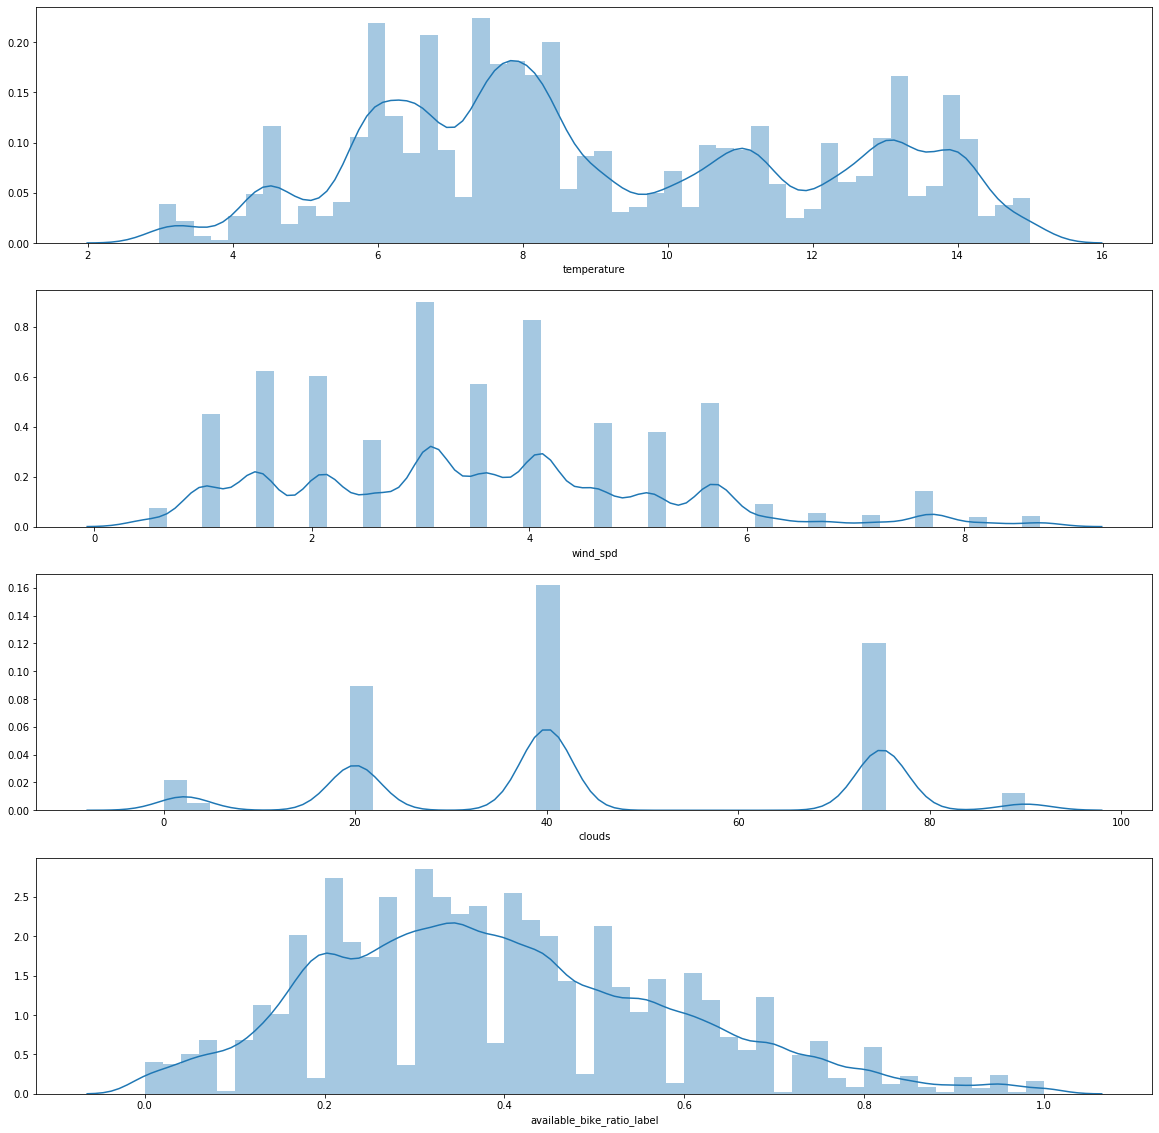

In [369]:
fig, axes = plt.subplots(4)
fig.set_size_inches(20, 20)
sns.distplot(combined_df["temperature"],ax=axes[0])
sns.distplot(combined_df["wind_spd"],ax=axes[1])
sns.distplot(combined_df["clouds"],ax=axes[2])
sns.distplot(combined_df["available_bike_ratio_label"],ax=axes[3])

In [370]:
cat_col = list(combined_df.select_dtypes(['category']).columns)
combined_df = one_hot_encoding(combined_df, cat_col)
combined_df

,number,latitude,longitude,bike_stand,banking,available_bike_ratio,available_bike_ratio_label,temperature,wind_spd,clouds,weekday_sin,weekday_cos,hour_sin,hour_cos,code_701,code_741,code_800,code_801,code_802,code_803
0,2,53.3568,-6.26814,20,1,0.850000,0.350000,11.80,1.0,75.0,0.974928,-0.222521,0.398401,-0.917211,0,0,0,0,0,1
1,3,53.3512,-6.26986,20,0,0.450000,0.150000,10.95,2.6,75.0,0.974928,-0.222521,0.398401,-0.917211,0,0,0,0,0,1
2,4,53.3469,-6.27298,20,0,0.700000,0.300000,10.95,2.6,75.0,0.974928,-0.222521,0.398401,-0.917211,0,0,0,0,0,1
3,5,53.3307,-6.26018,40,0,0.550000,0.344828,10.95,2.6,75.0,0.974928,-0.222521,0.398401,-0.917211,0,0,0,0,0,1
4,6,53.3434,-6.27012,20,0,0.300000,0.500000,11.80,1.0,75.0,0.974928,-0.222521,0.398401,-0.917211,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85317,87,53.3475,-6.28525,38,1,0.552632,0.425000,6.30,4.1,75.0,-0.974928,-0.222521,0.887885,0.460065,0,0,0,0,0,1
85318,88,53.3488,-6.28164,30,0,0.566667,0.421053,6.30,4.1,75.0,-0.974928,-0.222521,0.887885,0.460065,0,0,0,0,0,1
85319,89,53.3352,-6.25090,40,1,0.225000,0.206897,6.31,4.1,75.0,-0.974928,-0.222521,0.887885,0.460065,0,0,0,0,0,1
85320,90,53.3442,-6.23345,40,0,0.225000,0.575000,6.30,4.1,75.0,-0.974928,-0.222521,0.887885,0.460065,0,0,0,0,0,1


In [371]:
combined_df.dtypes

number                          int64
latitude                      float64
longitude                     float64
bike_stand                      int64
banking                         int32
available_bike_ratio          float64
available_bike_ratio_label    float64
temperature                   float64
wind_spd                      float64
clouds                        float64
weekday_sin                   float64
weekday_cos                   float64
hour_sin                      float64
hour_cos                      float64
code_701                        uint8
code_741                        uint8
code_800                        uint8
code_801                        uint8
code_802                        uint8
code_803                        uint8
dtype: object

In [372]:
combined_df.columns

Index(['number', 'latitude', 'longitude', 'bike_stand', 'banking',
       'available_bike_ratio', 'available_bike_ratio_label', 'temperature',
       'wind_spd', 'clouds', 'weekday_sin', 'weekday_cos', 'hour_sin',
       'hour_cos', 'code_701', 'code_741', 'code_800', 'code_801', 'code_802',
       'code_803'],
      dtype='object')

In [373]:
y_train = combined_df['available_bike_ratio_label']
x_train = combined_df.loc[:, combined_df.columns != 'available_bike_ratio_label']

In [374]:
size = len(x_train) * 9 //10 
x_train, x_test = x_train[:size], x_train[size:]
y_train, y_test = y_train[:size], y_train[size:]
print(size)

76789


In [375]:
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_train_std

array([[-1.73100372,  1.51232671, -0.18864443, ..., -0.39124743,
        -0.82581928,  1.64777951],
       [-1.70115293,  0.76898018, -0.282076  , ..., -0.39124743,
        -0.82581928,  1.64777951],
       [-1.67130213,  0.19819623, -0.45155652, ..., -0.39124743,
        -0.82581928,  1.64777951],
       ...,
       [-0.11906071, -0.9831938 ,  1.25682886, ...,  2.5559273 ,
        -0.82581928, -0.60687731],
       [-0.08920991, -0.77080908,  1.13460733, ...,  2.5559273 ,
        -0.82581928, -0.60687731],
       [-0.05935912, -0.82390526,  1.30517427, ...,  2.5559273 ,
        -0.82581928, -0.60687731]])

In [376]:
# model_param = { 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100],
#                  'max_features': ['auto', 'sqrt'],
#                  'min_samples_leaf': [1, 2, 4],
#                  'min_samples_split': [2, 5, 10],
#                  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1500]}

# #number of combinations
# n_iter = 100

# #intializing lgbm and lunching the search
# rf = RandomForestRegressor(random_state=42)
# grid_search = RandomizedSearchCV(
#     estimator=rf, 
#     param_distributions=model_param, 
#     n_iter=n_iter,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     refit=True,
#     random_state=42,
#     verbose=1,
#     n_jobs=-1)

# grid_search.fit(x_train_std, y_train)
# print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

# opt_parameters =  grid_search.best_params_

In [385]:
opt_parameters = {'n_estimators': 100}

In [386]:
print(opt_parameters)

{'n_estimators': 100}


In [387]:
%%time
rf_tuned = RandomForestRegressor(n_jobs= -1, **opt_parameters)
rf_tuned.fit(x_train, y_train)
scores=cross_val_score(rf_tuned, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print('{:.5f}'.format(np.mean(scores)))

-0.15391
CPU times: user 35.1 s, sys: 3.02 s, total: 38.1 s
Wall time: 26.3 s


In [388]:
print(scores)

[-0.14889393 -0.13837422 -0.15295662 -0.15306559 -0.17624607]


In [389]:
model_name = 'rf_model.pkl'
joblib.dump(rf_tuned, model_name, compress=3)

['rf_model.pkl']

In [390]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 879 ms, sys: 222 ms, total: 1.1 s
Wall time: 1.1 s


In [391]:
y_prediction = pd.Series(y_prediction)
y_prediction

0       0.321250
1       0.052375
2       0.085500
3       0.500000
4       0.418167
          ...   
8528    0.417154
8529    0.435689
8530    0.260299
8531    0.543910
8532    0.533567
Length: 8533, dtype: float64

In [392]:
y_test = y_test.reset_index()["available_bike_ratio_label"]
mean_squared_error(y_test, y_prediction, squared=False)

0.12072177366739788

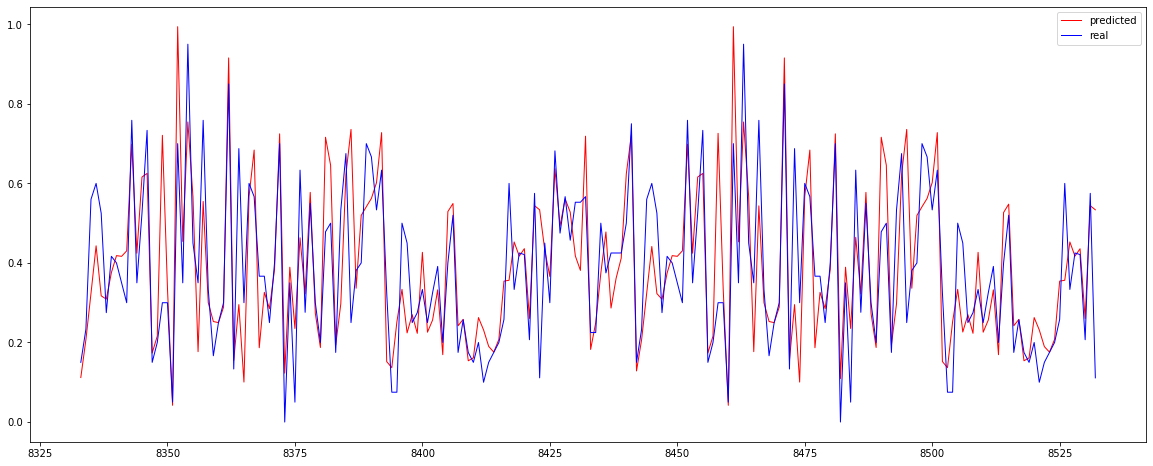

In [393]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(y_prediction[-200:], linewidth=1, color = 'red', label = 'predicted')
plt.plot(y_test[-200:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()

In [394]:
%%time
rf_sel = RandomForestRegressor(n_jobs= -1)
rf_sel.fit(x_train, y_train)
scores=cross_val_score(rf_sel, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print('{:.5f}'.format(np.mean(scores)))

-0.15456
CPU times: user 34.9 s, sys: 2.74 s, total: 37.6 s
Wall time: 25.9 s


In [335]:
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = rf_sel.feature_importances_
features

,feature,importance
0,number,0.284450
1,latitude,0.115674
2,longitude,0.106264
3,bike_stand,0.076403
4,banking,0.013760
5,available_bike_ratio,0.104224
6,temperature,0.072465
7,wind_spd,0.039210
8,clouds,0.020164
9,weekday_sin,0.033851


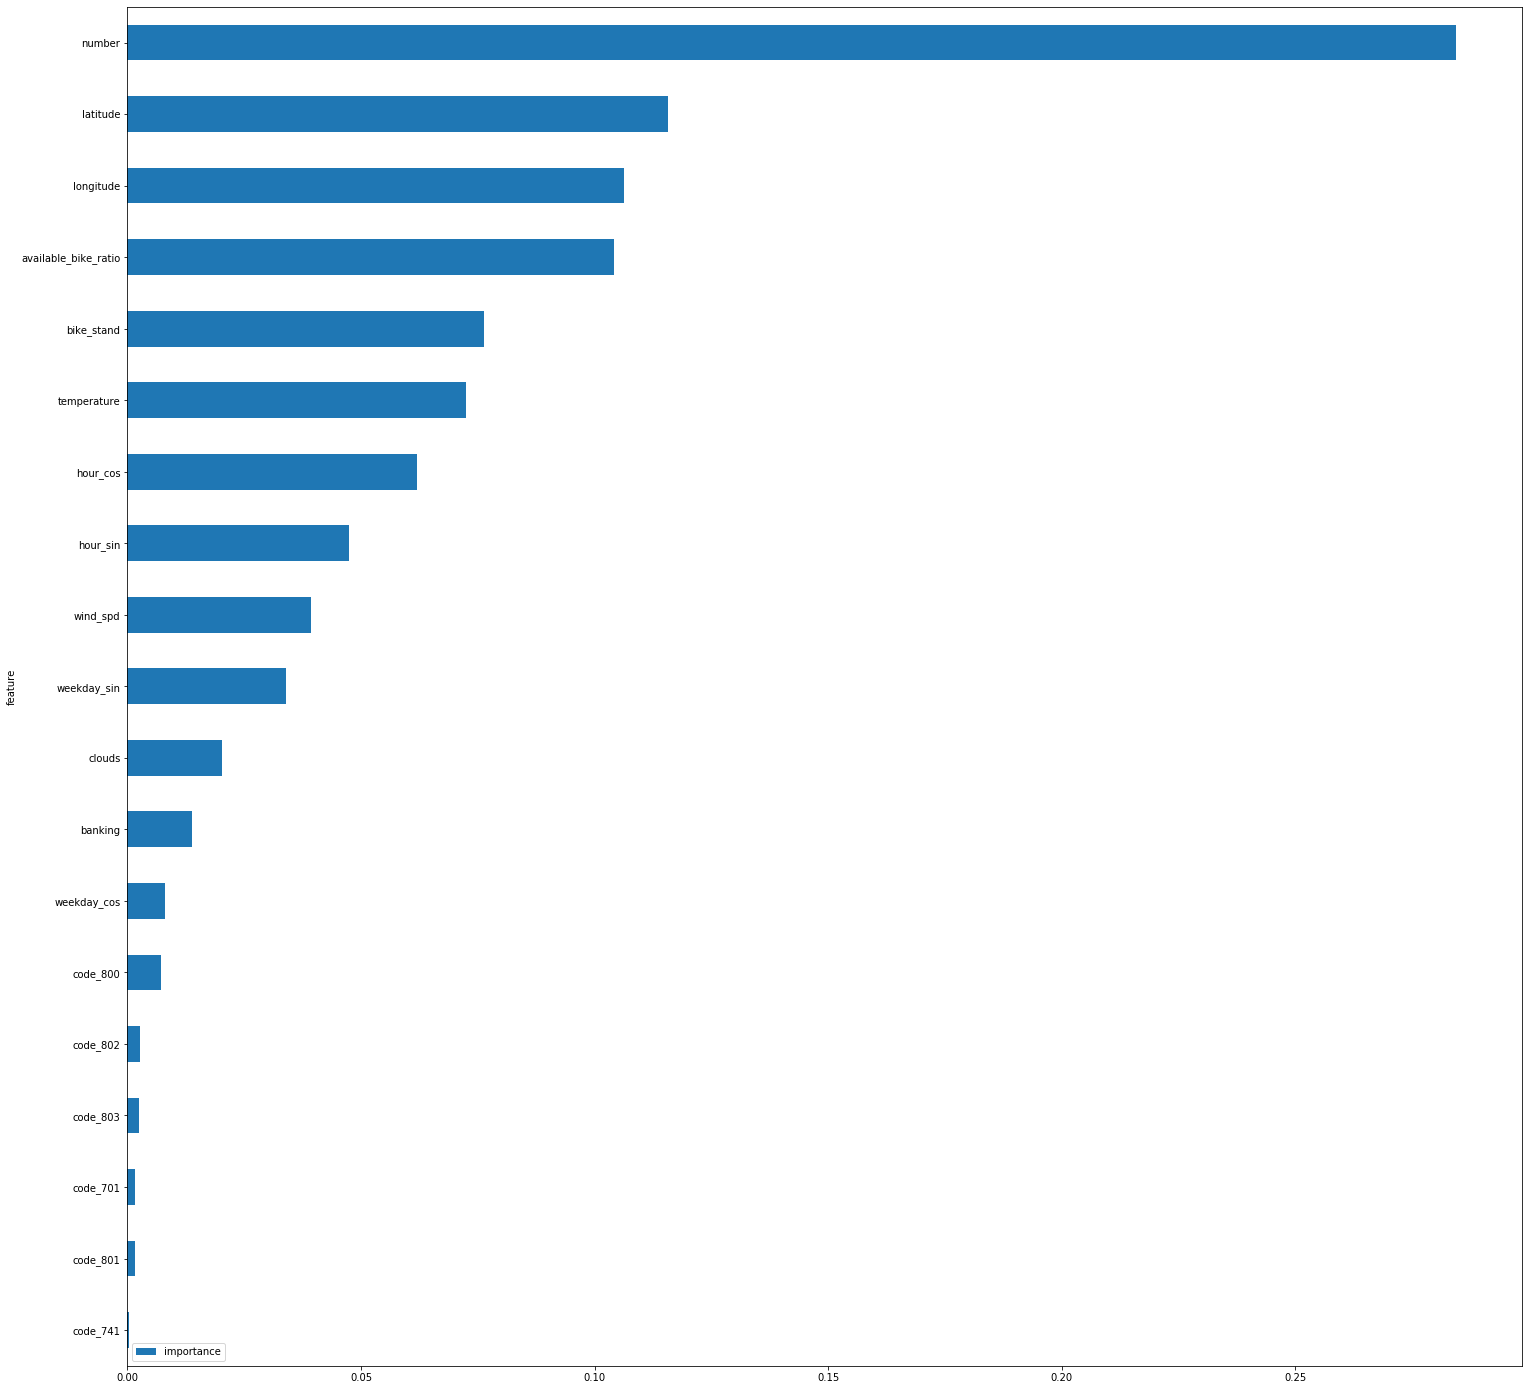

In [336]:
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(25, 25))

In [337]:
#feature selection
model = SelectFromModel(rf_sel, prefit=True)
x_train_reduced = model.transform(x_train)
print (x_train_reduced.shape)

(77956, 7)


In [338]:
x_test_reduced = model.transform(x_test)
print(x_test_reduced.shape)

(8662, 7)


In [339]:
%%time
rf_tuned = RandomForestRegressor(n_jobs= -1)
rf_tuned.fit(x_train_reduced, y_train)
scores=cross_val_score(rf_tuned, x_train_reduced, y_train, scoring='neg_root_mean_squared_error', cv=5)
print('{:.5f}'.format(np.mean(scores)))

-0.15868
CPU times: user 22.8 s, sys: 2.92 s, total: 25.7 s
Wall time: 16 s


In [340]:
print(scores)

[-0.16021075 -0.14052597 -0.16920153 -0.14478304 -0.17868796]


In [341]:
model_name = 'rf_model.pkl'
with open(model_name, 'wb') as handle:
    pickle.dump(rf_tuned, handle, pickle.HIGHEST_PROTOCOL)

In [342]:
%%time
with open(model_name, 'rb') as handle:     
    model = pickle.load(handle)  
y_prediction = model.predict(x_test_reduced)

CPU times: user 179 ms, sys: 165 ms, total: 344 ms
Wall time: 331 ms


In [343]:
y_prediction = pd.Series(y_prediction)
y_prediction

0       0.300000
1       0.850000
2       0.133333
3       0.685625
4       0.300000
          ...   
8657    0.199500
8658    0.226714
8659    0.192190
8660    0.169196
8661    0.251000
Length: 8662, dtype: float64

In [344]:
y_test = y_test.reset_index()["available_bike_ratio_label"]
mean_squared_error(y_test, y_prediction, squared=False)

0.1177397599146474

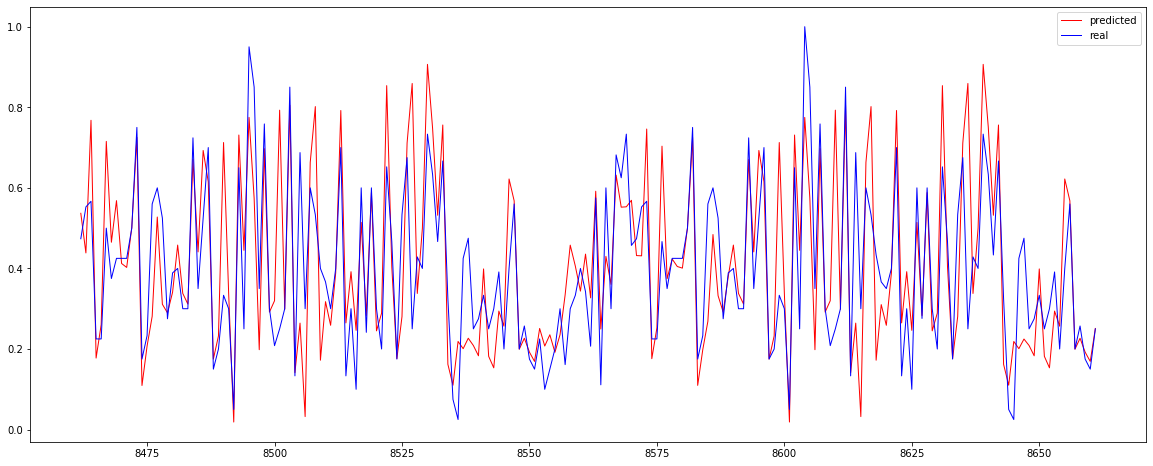

In [345]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(y_prediction[-200:], linewidth=1, color = 'red', label = 'predicted')
plt.plot(y_test[-200:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()